In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats
from scipy import stats
from scipy.stats import ttest_rel
from scipy.stats import ttest_ind
from scipy.stats import shapiro
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu

from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.stattools import omni_normtest

from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.api import qqplot, add_constant

from sklearn.preprocessing import scale, minmax_scale, robust_scale
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from statsmodels.tools.eval_measures import rmse

%matplotlib inline
sns.set(font="AppleGothic")
plt.rcParams['axes.unicode_minus']=False

from sklearn.tree import export_graphviz
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor

import os
os.environ['PATH']+=os.pathsep+'/Users/dasol/opt/anaconda3/lib/python3.8/site-packages/graphviz'

# 콘크리트 강도 예측
## Random Forest 방법 적용

In [2]:
df = pd.read_csv('Concrete.csv', engine='python', encoding='cp949')
df.head(n=3)

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27


### test 데이터 40%로 약 400개이다.

In [3]:
df_raw_y = df['strength']
df_raw_x = df.drop('strength', axis=1, inplace=False)

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, test_size=0.4, random_state=1234)

print('train data X size: {}'.format(df_train_x.shape))
print('train data Y size: {}'.format(df_train_y.shape))
print('test data X size: {}'.format(df_test_x.shape))
print('test data Y size: {}'.format(df_test_y.shape))

train data X size: (618, 8)
train data Y size: (618,)
test data X size: (412, 8)
test data Y size: (412,)


# 1. 모델 생성
## score해석
모델의 설명력은 train 98%, test 90.3%로 설명력이 좋은 상태이다.

이는 Decision Tree 1개로 분석한 score 78.9% 훨씬 좋은 결과이다.

In [13]:
rf_uncustomized = RandomForestRegressor(random_state=1234)
rf_uncustomized.fit(df_train_x, df_train_y)

print('Tree_uncustomized Score on training set: {:3f}'.format(rf_uncustomized.score(df_train_x, df_train_y)))
print('Tree_uncustomized Score on test set: {:3f}'.format(rf_uncustomized.score(df_test_x, df_test_y)))

Tree_uncustomized Score on training set: 0.980068
Tree_uncustomized Score on test set: 0.903987


# 1-1. 모델 파라메터 조정: 트리 수
### 해석
트리 수 증가에 따라 모델의 설명력은 감소하므로, train과 test 데이터의 성능이 70% 이상인 트리 수 20을 선택하였다.


In [32]:
train_score, test_score = [], []
para_n_tree= [n_tree*10 for n_tree in range(1,11)] 
# 트리 수 변경에 따른 모델 성능
for v_n_estimators in para_n_tree:
    tree = RandomForestRegressor(random_state=1234, min_samples_leaf=v_n_estimators)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))

df_score_n = pd.DataFrame()
df_score_n['n_estimators'] = para_n_tree
df_score_n['TrainScore'] = train_score 
df_score_n['TestScore'] = test_score
df_score_n.round(3)

,n_estimators,TrainScore,TestScore
0,10,0.878,0.827
1,20,0.815,0.766
2,30,0.773,0.730
3,40,0.734,0.694
4,50,0.693,0.658
5,60,0.644,0.613
6,70,0.585,0.557
7,80,0.555,0.533
8,90,0.538,0.506
9,100,0.525,0.495


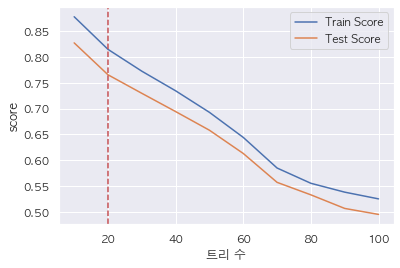

In [33]:
plt.plot(para_n_tree, train_score, linestyle='-', label = 'Train Score')
plt.plot(para_n_tree, test_score, linestyle='-', label = 'Test Score')
plt.axvline(x = 20, color = 'r', linestyle = '--')
plt.xlabel('트리 수')
plt.ylabel('score')
plt.legend()

# 1-2. 모델 파라메터 조정: 잎사귀 노드의 최소 자료 수
### 해석
train과 test 데이터의 성능 차이가 작은 8 선택


In [34]:
train_score, test_score = [], []
min_leaf= [n_leaf for n_leaf in range(1,20)] # 잎사귀 최소 자료 수

for v_min_samples in min_leaf:
    tree = RandomForestRegressor(random_state=1234, n_estimators=20,min_samples_leaf=v_min_samples)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))

df_score_leaf = pd.DataFrame()
df_score_leaf['MinSampleLeaf'] = min_leaf 
df_score_leaf['TrainScore'] = train_score 
df_score_leaf['TestScore'] = test_score
df_score_leaf.round(3)

,MinSampleLeaf,TrainScore,TestScore
0,1,0.978,0.905
1,2,0.964,0.898
2,3,0.950,0.888
3,4,0.937,0.874
4,5,0.922,0.868
5,6,0.910,0.857
6,7,0.900,0.849
7,8,0.892,0.845
8,9,0.883,0.836
9,10,0.873,0.823


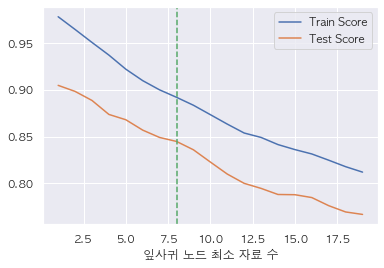

In [35]:
plt.plot(min_leaf, train_score, linestyle='-', label = 'Train Score')
plt.plot(min_leaf, test_score, linestyle='-', label = 'Test Score')
plt.axvline(x = 8, color = 'g', linestyle = '--')
plt.xlabel('잎사귀 노드 최소 자료 수')
plt.legend()

# 1-2. 모델 파라메터 조정: 분리 노드의 최소 자료 수
### 해석
train_score, test_score 의 차이가 작고 score 높은 16 선택

In [38]:
train_score, test_score = [], []
min_split= [n_split*2 for n_split in range(2,20)] # 분리 노드의 최소 자료 수

for v_min_samples in min_split:
    tree = RandomForestRegressor(random_state=1234, n_estimators=20,min_samples_leaf=8, min_samples_split=v_min_samples)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))

df_score_leaf = pd.DataFrame()
df_score_leaf['MinSampleSplit'] = min_split
df_score_leaf['TrainScore'] = train_score 
df_score_leaf['TestScore'] = test_score
df_score_leaf.round(3)

,MinSampleSplit,TrainScore,TestScore
0,4,0.892,0.845
1,6,0.892,0.845
2,8,0.892,0.845
3,10,0.892,0.845
4,12,0.892,0.845
5,14,0.892,0.845
6,16,0.892,0.845
7,18,0.888,0.839
8,20,0.883,0.833
9,22,0.878,0.826


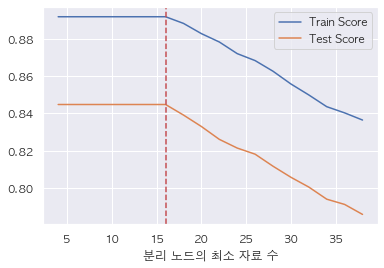

In [40]:
plt.plot(min_split, train_score, linestyle='-', label = 'Train Score')
plt.plot(min_split, test_score, linestyle='-', label = 'Test Score')
plt.axvline(x = 16, color = 'r', linestyle = '--')
plt.xlabel('분리 노드의 최소 자료 수')
plt.legend()

# 1-3. 모델 파라메터 조정: 최대 깊이
## 선택=>8
이유: train_score, test_score가 8 이후로 비슷하게 유자되지만 과대적합 방지를 위해 그중 가장 작은 8 선택

In [46]:
train_score, test_score = [], []
para_depth= [i for i in range(1,11)] # 분리 노드의 최소 자료 수

for v_depth in para_depth:
    tree = RandomForestRegressor(random_state=1234, n_estimators=20, min_samples_leaf=8, min_samples_split=16, max_depth=v_depth)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))

df_score_depth = pd.DataFrame()
df_score_depth['Maxdepth'] = para_depth
df_score_depth['TrainScore'] = train_score 
df_score_depth['TestScore'] = test_score
df_score_depth.round(3)

,Maxdepth,TrainScore,TestScore
0,1,0.373,0.360
1,2,0.612,0.590
2,3,0.729,0.680
3,4,0.804,0.761
4,5,0.859,0.816
5,6,0.881,0.837
6,7,0.889,0.843
7,8,0.891,0.845
8,9,0.892,0.845
9,10,0.892,0.845


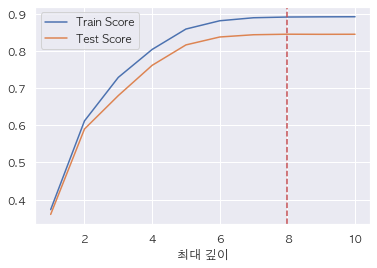

In [47]:
plt.plot(para_depth, train_score, linestyle='-', label = 'Train Score')
plt.plot(para_depth, test_score, linestyle='-', label = 'Test Score')
plt.axvline(x = 8, color = 'r', linestyle = '--')
plt.xlabel('최대 깊이')
plt.legend()

# 선택한 파라메터를 적용한 모델의 score

In [54]:
rf_last = RandomForestRegressor(random_state=1234, n_estimators=20, min_samples_leaf=8, min_samples_split=16, max_depth=8)
rf_last.fit(df_train_x, df_train_y)
print('Score on training set: {:.3f}'.format(rf_final.score(df_train_x, df_train_y)))
print('Score on test set: {:.3f}'.format(rf_final.score(df_test_x, df_test_y)))

Score on training set: 0.891
Score on test set: 0.845


# 3.최종 모델
## 파라메터: 트리개수=10, 잎사귀 노드 최소 자료 수=1, 분리 노드의 최소 자료 수=2, 최대 깊이=None

## 해석
- 굵은 입자 콘크리트 재료의 중요도:  Decision Tree 1개를 사용했을 때는 0이었지만, 중요도가 0.039로 생겼습니다.

- 랜덤 포레트트의 파라메터를 트리개수=20, 잎사귀 노드 최소 자료 수=8, 분리 노드의 최소 자료 수=16, 최대 깊이=8로 수정한 결과, 모델의 score은 train 89.1%, test 84.5%이다.

    - 이는 Decision Tree 1개로 분석한 score 78.9% 보다는 발전된 결과이지만, 

    - 파라메터를 수정하지 않은 기본 모델의 설명력은 train 98%, test 90.3%보다 낮아진 결과이다.

    - 이유는 무엇일까?
        - 파라메터 선정이 잘못 되었을 것이라 추측됩니다.

        - 다른 파라메터 조합으로 실험이 필요합니다.


## 최종 해석
- 트리 분리에 영향이 큰 변수 3가지: Decision Tree 1개를 사용했을 때와 마찬가지로, 트리 분리에 영향이 큰 변수 3가지는 순서대로 age(연식), cement(시멘트 종류), water(물 함량)입니다.

- 추가적으로 superplasticizer(고강도 콘크리트를 만드는데 사용되는 첨가제)의 중요도가 4위로 중요 변수입니다.

- Decision Tree 1개의 분석 결과와 비교:
    - fly_ash(석탄원료의 부산물, 시맨트 재료)의 중요도가 4위->8위로 감소했습니다.
    - 순위 변동의 이유는? Decision Tree의 변수 중요도 순위는 data split에 따라 변동 가능하기 때문입니다.


In [58]:
df_importance = pd.DataFrame()
feature_name = df_train_x.columns
df_importance['Feature'] = feature_name
df_importance['Importance'] = rf_uncustomized.feature_importances_
df_importance.sort_values('Importance', ascending=True, inplace=True)
df_importance.round(3)


,Feature,Importance
2,fly_ash,0.024
5,coarse_aggregate,0.039
6,fine_aggregate,0.048
1,blast_furnace_slag,0.051
4,superplasticizer,0.085
3,water,0.150
0,cement,0.261
7,age,0.342


Text(0, 0.5, '변수')

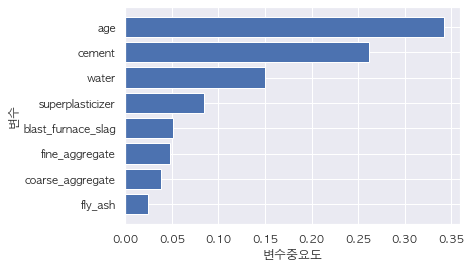

In [59]:
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수중요도')
plt.ylabel('변수')

# 4.GridSearchCV: 모델 parameter 자동 조정
## 최적 파라메터: 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 4

앞선 분석에서 임의로 선택한 파라메터 조합 (트리개수=20, 잎사귀 노드 최소 자료 수=8, 분리 노드의 최소 자료 수=16, 최대 깊이=8)과 많은 차이가 난다.

특히 잎사귀 노드 최소 자료 수=1로 과적합을 유도하는 숫자이지만, Randomforest에서는 각 트리가 과적합 되는 것이 총 평균 score를 높이는데 도움이 되기 때문에 1개가 최적값인 것으로 해석된다.

## score: 0.869
GridSearchCV로 찾아낸 파라메터 세트로 의사결정 트리 분석을 하면 콘크리트 강도 설명력이 86.9%이다.

In [60]:
estimator = RandomForestRegressor(random_state=1234)
param_grid = {'max_depth': para_depth, 
             'min_samples_split':min_split, 'min_samples_leaf':min_leaf}
grid_dt = GridSearchCV(estimator, param_grid, scoring='r2', n_jobs=-1)
grid_dt.fit(df_train_x, df_train_y)

GridSearchCV(estimator=RandomForestRegressor(random_state=1234), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19],
                         'min_samples_split': [4, 6, 8, 10, 12, 14, 16, 18, 20,
                                               22, 24, 26, 28, 30, 32, 34, 36,
                                               38]},
             scoring='r2')

In [61]:

print('best estimator model:\n',grid_dt.best_estimator_)
print('\nbest parameter:\n',grid_dt.best_params_)
print('\nbest score:\n',grid_dt.best_score_.round(3))

best estimator model:
 RandomForestRegressor(max_depth=10, min_samples_split=4, random_state=1234)

best parameter:
 {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 4}

best score:
 0.869
